### **"Предыстория"**

Мы компания ООО "Какая милота :3", которая владеет видеохостингом "Show me cats!"

**Show me cats!** - популярный видеохостинг, на котором показывают только видеоролики с котиками. На нашей платформе есть НУ ОЧЕНЬ навязчивая реклама при просмотре данных видеороликов, при этом 40% дохода с рекламы и подписок щедро отдается в приюты, о чем мы открыто заявляем и подкрепляем свои слова доказательствами в социальных сетях. Дабы смотреть видеоролики без рекламы, на платформе реализована система подписки "Show me unlimited cats!".

На наши головы снизошло озарение, что если мы дадим пользователю посмотреть первую минуту видеоролика без рекламы, в ходе которой появится плашка "Понравилось без рекламы? Оформите подписку!", то количество вовлеченных пользователей, оформивших подписку возрастет.

Предыстория усе, смотрите "Гипотезы и метрики"

### **ВАЖНО - ПОСМОТРИТЕ "ПРЕДЫСТОРИЮ" ПЕРЕД ТЕМ КАК ЧИТАТЬ ЭТО** (я старался..)

#### **Гипотеза**

*Если мы дадим пользователям посмотреть первую минуту видеоролика без рекламы и с плашкой "Купите подписку" (см. предыстория), то это повысит конверсию в подписку, потому что пользователи захотят сохранить свой опыт просмотра без рекламы, особенно зная, что часть денег пойдет на помощь приютам.*

##### **Гипотеза H0**
Конверсия группы B (С фичей) <= конверсии группы А (Без фичи) (Отсутствие эффекта)

##### **Гипотеза H1**
Конверсия группы В > конверсии группы А (Эффект есть!)

##### **Метрики**

*Основная метра*
    Конверсия пользователей в подписку

*Дополнительные метрики*
    1. Проведенное время за просмотром видео 
    2. Количество страниц, просмотренных пользователем
    3. Регион (где котов любят больше?)

### **Анализ входных данных (EDA)**


#### *Загрузим данные и посмотрим на их состав:*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest

path = Path('./data/ab_testing.csv')
df = pd.read_csv(path)
df["Conversion"] = df["Conversion"].map({"Yes": 1, "No": 0}).astype(int)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   int64 
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(4), object(3)
memory usage: 273.6+ KB
None


Данные состоят из 5000 строк, описывающих **поведение** пользователей на нашем сервисе, а также данные об их **устройстве** и **местоположении**.

#### *Проверим данные на пробелы*

In [2]:
print(df.isnull().sum())

User ID       0
Group         0
Page Views    0
Time Spent    0
Conversion    0
Device        0
Location      0
dtype: int64


Данные **целостные**, в них нет пропусков.

#### *Описание данных:*

In [3]:
print(df.drop("User ID", axis=1).describe().apply(lambda x: x.round(2)))

       Page Views  Time Spent  Conversion
count     5000.00     5000.00      5000.0
mean         7.54      242.51         0.1
std          4.02      118.25         0.3
min          1.00       40.00         0.0
25%          4.00      137.00         0.0
50%          8.00      243.00         0.0
75%         11.00      346.00         0.0
max         14.00      449.00         1.0


Средняя конверсия составляет **10%**. Средние время просмотра и количество просмотров **242.51** и **7.54** соответсвенно.

#### *Сравнение A и B групп*

In [4]:
print(df[["Group", "Conversion", "Page Views", "Time Spent"]].groupby("Group").describe().apply(lambda x: x.round(3)).T)

Group                    A         B
Conversion count  2519.000  2481.000
           mean      0.054     0.141
           std       0.226     0.348
           min       0.000     0.000
           25%       0.000     0.000
           50%       0.000     0.000
           75%       0.000     0.000
           max       1.000     1.000
Page Views count  2519.000  2481.000
           mean      7.582     7.493
           std       4.080     3.963
           min       1.000     1.000
           25%       4.000     4.000
           50%       8.000     8.000
           75%      11.000    11.000
           max      14.000    14.000
Time Spent count  2519.000  2481.000
           mean    241.733   243.304
           std     117.340   119.194
           min      40.000    40.000
           25%     137.500   136.000
           50%     241.000   244.000
           75%     343.000   348.000
           max     449.000   449.000


Данные разделены приблизительно поровну. Группа B имеет **значительное** увеличение в средней конверсии при небольшом изменении во времени просмотра и количестве просмотров.

### **Визуализация**

Text(0.5, 1.0, 'Зависимость: Количество просмотров → Количество конверсий')

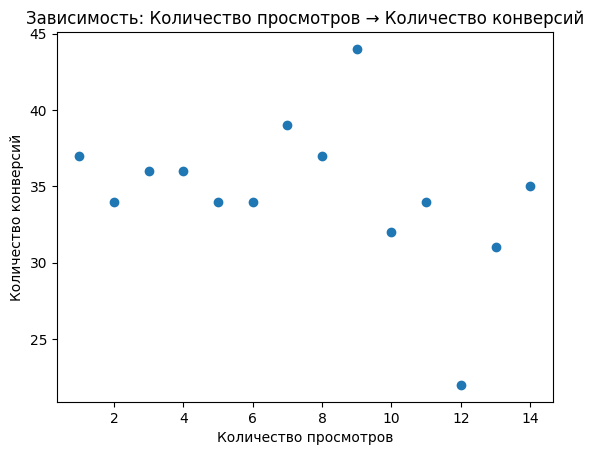

In [5]:
df_plot = df.copy()

conversion_sum = df_plot.groupby("Page Views", observed=True)["Conversion"].sum().reset_index()

plt.scatter(conversion_sum["Page Views"], conversion_sum["Conversion"])

plt.xlabel("Количество просмотров")
plt.ylabel("Количество конверсий")
plt.title("Зависимость: Количество просмотров → Количество конверсий")

Text(0.5, 1.0, 'Зависимость: Время просмотра → Количество конверсий')

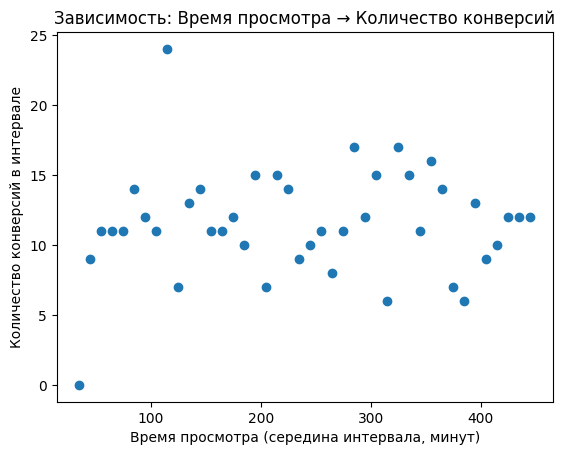

In [6]:
df_plot = df.copy()

df_plot["Time_intervals"] = pd.cut(df_plot['Time Spent'], bins=np.arange(0, df_plot["Time Spent"].max()+10, 10))

conversion_sum = df_plot.groupby("Time_intervals", observed=True)["Conversion"].sum().reset_index()
intervals_mid = conversion_sum["Time_intervals"].apply(lambda x: x.mid)
plt.scatter(intervals_mid, conversion_sum["Conversion"])

plt.xlabel("Время просмотра (середина интервала, минут)")
plt.ylabel("Количество конверсий в интервале")
plt.title("Зависимость: Время просмотра → Количество конверсий")

По графикам можно понять, что ни время просмотра, ни количество просмотров **не оказывает** значительного влияния на количество конверсий.

### **Проверим объёмы групп**

#### *Объём группы*

In [7]:
group_counts = df['Group'].value_counts()
print(f"Всего: {group_counts['A'] + group_counts['B']} ")
print(f"Группа A: {group_counts['A']} пользователей ({group_counts['A']/len(df)*100:.2f}%)")
print(f"Группа B: {group_counts['B']} пользователей ({group_counts['B']/len(df)*100:.2f}%)")

Всего: 5000 
Группа A: 2519 пользователей (50.38%)
Группа B: 2481 пользователей (49.62%)


### **Проверим рандомизацию**

#### *По устройствам*

##### **Кол-во**

In [8]:
print(pd.crosstab(df['Group'], df['Device'], margins=True, margins_name="Всего"))

Device  Desktop  Mobile  Всего
Group                         
A          1244    1275   2519
B          1294    1187   2481
Всего      2538    2462   5000


##### **Процентная доля**

In [9]:
print(pd.crosstab(df['Group'], df['Device'], normalize='index').round(3) * 100)

Device  Desktop  Mobile
Group                  
A          49.4    50.6
B          52.2    47.8


#### *Различия в процентных долях типов устройств между группами A и B незначительны (десктоп - 2.8%, мобайл - 2,8%)*

#### *По локациям*

##### **Кол-во**

In [10]:
print(pd.crosstab(df['Group'], df['Location'], margins=True, margins_name="Всего"))

Location  England  Northern Ireland  Scotland  Wales  Всего
Group                                                      
A             606               614       670    629   2519
B             640               628       611    602   2481
Всего        1246              1242      1281   1231   5000


##### **Процентная доля**

In [11]:
print(pd.crosstab(df['Group'], df['Location'], normalize='index').round(3) * 100)

Location  England  Northern Ireland  Scotland  Wales
Group                                               
A            24.1              24.4      26.6   25.0
B            25.8              25.3      24.6   24.3


#### *Различия в процентных долях типов устройств между группами A и B незначительны (не более 2%)*

### **Расчёт MDE**

#### *Подготовка данных*

In [12]:
baseline_conversion = df[df['Group'] == 'A']['Conversion'].mean()
n = group_counts['A']
alpha = 0.05
power = 0.95
beta = 0.05
z_alpha = norm.ppf(1 - alpha/2)
z_beta = norm.ppf(power)
dispersion_sum = 2 * baseline_conversion * (1 - baseline_conversion)
numerator = (z_alpha + z_beta) ** 2 * dispersion_sum

#### *Расчёт MDE*

In [13]:
mde = np.sqrt(numerator/n)
print("MDE: ", mde)

MDE:  0.022955540245400436


### **Проверим статистическую значимость**

#### ***Целевая метрика***

##### Конверсия пользователей в подписку

In [24]:
converted_A = df[df['Group'] == 'A']['Conversion'].sum()
nobs_A = df[df['Group'] == 'A'].shape[0]
converted_B = df[df['Group'] == 'B']['Conversion'].sum()
nobs_B = df[df['Group'] == 'B'].shape[0]
stat, p_value = proportions_ztest([converted_B, converted_A], [nobs_B, nobs_A], alternative='larger')

In [25]:
p_A = converted_A / nobs_A
p_B = converted_B / nobs_B
p_total = (converted_A + converted_B) / (nobs_A + nobs_B)
se_diff = np.sqrt(p_total * (1 - p_total) * (1/nobs_A + 1/nobs_B))

##### *Стандартная ошибка разницы пропорций*

In [26]:
print(se_diff)

0.008371191530404713


##### *Z-статистика*

In [29]:
print(stat)

10.354488520266216


##### *P-value*

In [30]:
print(p_value)

1.9965755947100969e-25


Значение p-value крайне мало, что говорит о том, что эффект от mde реален, а не случаен. Шанс ошибиться - ооооооочень маленький.

In [31]:
print(p_value < 0.05)

True


Отвергаем нулевую гипотезу (H0). Есть статистически значимое увеличение конверсии в группе B по сравнению с группой A.

ниже второстепенные метрики

In [44]:
from scipy.stats import ttest_ind
time_A = df[df['Group'] == 'A']['Time Spent']
time_B = df[df['Group'] == 'B']['Time Spent']
stat_time, p_val_time = ttest_ind(time_A, time_B)
views_A = df[df['Group'] == 'A']['Page Views']
views_B = df[df['Group'] == 'B']['Page Views']
stat_views, p_val_views = ttest_ind(views_A, views_B)

In [45]:
print("значение времени ниже")

значение времени ниже


In [46]:
print(p_val_time)

0.6386980515632603


In [47]:
print("значение просмотров ниже")


значение просмотров ниже


In [48]:
print(p_val_views)

0.4360228594083837
